In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chelseaeverest","key":"fc6a2ae8f69e0a089247ce27a243ec7b"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c dogs-vs-cats

 99% 807M/812M [00:20<00:00, 41.0MB/s]
100% 812M/812M [00:20<00:00, 41.5MB/s]


In [6]:
!unzip -qq dogs-vs-cats.zip

In [7]:
!unzip -qq train.zip

In [9]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

Utility function to copy cat and dog images from index start_index to index end_index to the subdirectory new_base_dir/{subset_name}/cat (and /dog). The "subset_name" will be either "train", "validation", or "test"

In [10]:
def make_subset (subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg"
              for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src = original_dir / fname,
                      dst = dir / fname)

In [11]:
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

A convnet stack of alternated Conv2D (with relu activation) and MaxPooling2D layers

Rescaling layer rescales image inputs (whose values are originally in the [0,255] range) to the [0,1] range

Because this is a binary classification problem, we'll end the model with a single unit (a Dense layer of size 1) and a sigmoid activation

In [20]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [21]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [16]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [17]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(train_dataset,
                    epochs= 30,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 236s 4s/step - loss: 0.6975 - accuracy: 0.5075 - val_loss: 0.6919 - val_accuracy: 0.5380
Epoch 2/30
63/63 [==============================] - 220s 3s/step - loss: 0.6933 - accuracy: 0.5335 - val_loss: 0.6898 - val_accuracy: 0.5150
Epoch 3/30
63/63 [==============================] - 201s 3s/step - loss: 0.6820 - accuracy: 0.5615 - val_loss: 0.6594 - val_accuracy: 0.5900
Epoch 4/30
63/63 [==============================] - 238s 4s/step - loss: 0.6401 - accuracy: 0.6365 - val_loss: 0.6399 - val_accuracy: 0.6170
Epoch 5/30
63/63 [==============================] - 212s 3s/step - loss: 0.5845 - accuracy: 0.6895 - val_loss: 0.6115 - val_accuracy: 0.6600
Epoch 6/30
63/63 [==============================] - 243s 4s/step - loss: 0.5606 - accuracy: 0.7155 - val_loss: 0.6604 - val_accuracy: 0.6350
Epoch 7/30
63/63 [==============================] - 216s 3s/step - loss: 0.5307 - accuracy: 0.7365 - val_loss: 0.6208 - val_accuracy: 0.6860
Epoch 8/30
63

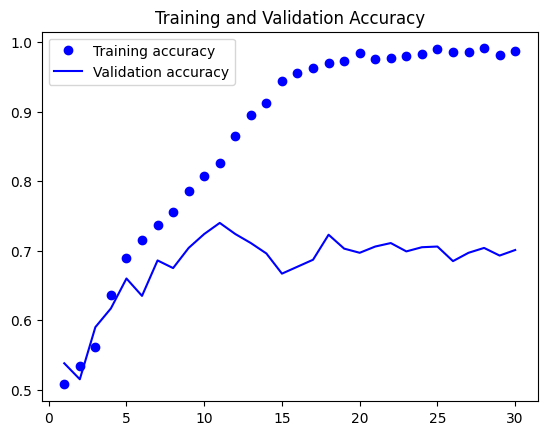

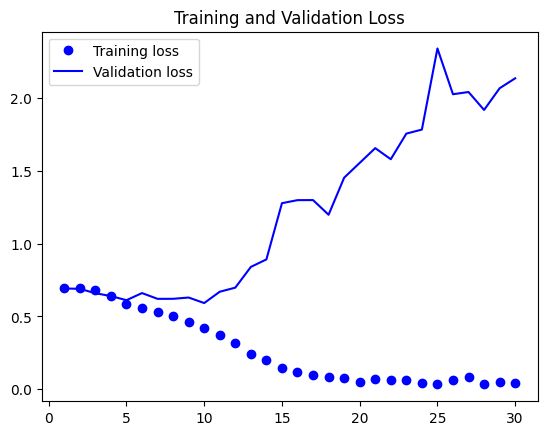

In [22]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [23]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 54s 845ms/step - loss: 0.5871 - accuracy: 0.7135
Test accuracy: 0.714


Including Data Augmentation

In [25]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

*   RandomFlip("horizontal") - Applies a horizontal flip to 50% of the images
*   RandomRotation(0.1) - Rotates the input images by a random value in the range [-10% to +10%] (fractions of a circle [-36 degrees to +36 degrees])
*   RandomZoom(0.2) - Zooms in or out by a factor of [-20% to +20%]


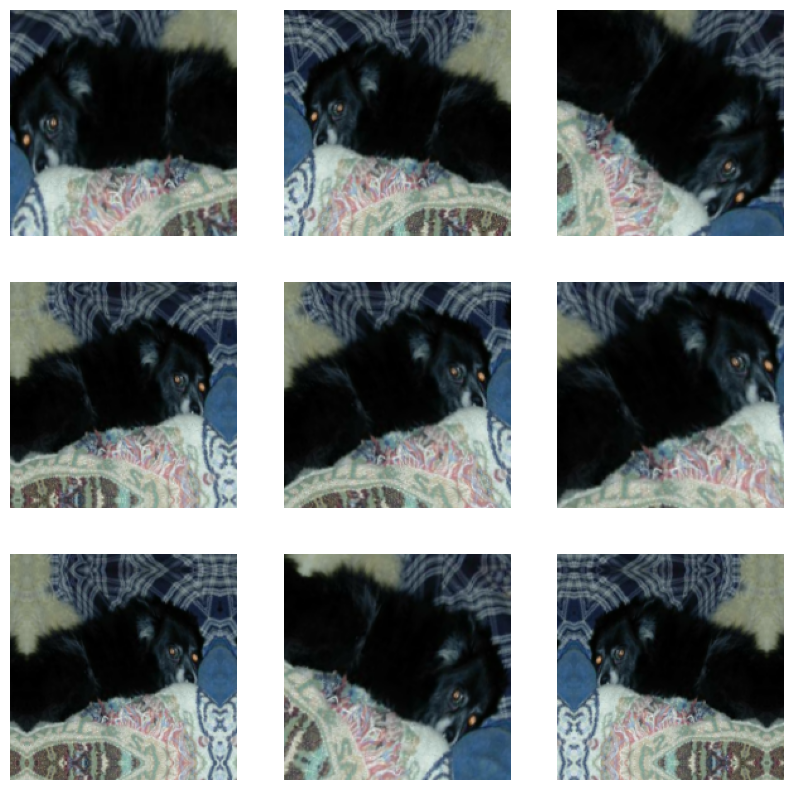

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

We can use take(N) to only sample N batches from the dataset. This is equivalent to inserting a break in the loop after the Nth batch

In [27]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [28]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(train_dataset,
                    epochs= 100,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 226s 4s/step - loss: 0.6982 - accuracy: 0.4955 - val_loss: 0.6915 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 218s 3s/step - loss: 0.6970 - accuracy: 0.5160 - val_loss: 0.8662 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 217s 3s/step - loss: 0.6792 - accuracy: 0.5790 - val_loss: 0.6446 - val_accuracy: 0.6200
Epoch 4/100
63/63 [==============================] - 219s 3s/step - loss: 0.6499 - accuracy: 0.6225 - val_loss: 0.6314 - val_accuracy: 0.6510
Epoch 5/100
63/63 [==============================] - 221s 3s/step - loss: 0.6264 - accuracy: 0.6610 - val_loss: 0.6004 - val_accuracy: 0.6800
Epoch 6/100
63/63 [==============================] - 218s 3s/step - loss: 0.5944 - accuracy: 0.6865 - val_loss: 0.5913 - val_accuracy: 0.6960
Epoch 7/100
63/63 [==============================] - 216s 3s/step - loss: 0.5741 - accuracy: 0.6895 - val_loss: 0.6112 - val_accuracy: 0.6860
Epoch 

KeyboardInterrupt: ignored

I wanted to go to sleep and didn't want to keep it running haha ^

In [29]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 53s 835ms/step - loss: 0.5494 - accuracy: 0.7235
Test accuracy: 0.724
